# Generate a List of Strong / Good Lines

## Contents
- [Get set up](#getsetup)
- [Step 1: Reduce the full line list](#step1)
- [Step 2: Further reduce the line list with Moog](#step2)
- [(Optional) Step 3: Further customize your line list](#step3)
- [(Optional) Compare line lists](#comparelinelists)


### Problem:   
We can easily and quickly generate a very detailed line list for a spectral region using linemake.  However, this line list is often more detailed than necessary, especially when doing a 'quick' abundance analysis.  For example, many lines in the full line list may not be significant or detectably present in our spectrum.

### Goal:  
Given a spectrum and a full line list, generate a list strong / good lines specifically curated for the given spectrum

### Challenges:
We could run the full line list through the moog loooper function to see if the line is a 3sigma detection, but this would take a very long time to do as the full line list may have tens of thousands of lines.  So first, we must develop a way of reducing the initial full line list.  Then we can test this list for detections. 


### Requirements:  
A continuum normalized and radial velocity corrected spectrum and a full line list. 

# Get set up <a id='getsetup'></a>

In [1]:
import os
import sys
import shutil
from scipy.signal import find_peaks
import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


import numpy as np

from astropy.io import ascii
from astropy.table import Table

from scipy.signal import savgol_filter

# # A bunch of functions to interface with MOOG
# import moog_funcs as mf

# ----------------- Import the other files of functions
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import asap_lib.moog_funcs as mf
import asap_lib.spectra as sa
import asap_lib.auto_atmosphere as aa
import asap_lib.calc_abunds as calc_abunds
import asap_lib.line_list_utils as llu
from asap_lib.config import dataDir



import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.interpolate import interp1d

%matplotlib notebook

**Read in the master/full line list**

In [26]:
path = 'asap_lib/data/linelists/linemake_lists/'
file =  'll.4600.4999' # 'll.3500.3999'  'll.4000.4600'

# Make a copy of the master line list in the working directory to prevent changes to the original file
shutil.copyfile(path+file, file)

# ---------- Optional: Keep only specific species 
# For example, if you want to only have iron lines use [26.0, 26.1]
# For example, if you want to only have europium lines use [63.0, 63.1]
llu.keep_only_species_in_list( file, [63.0, 63.1] )

# ---------- Optional: Trim out specific species 
# For example, if you don't want any iron lines, use [26.0, 26.1]
# llu.trim_species_from_list( file, [] )


# ----------
ll, ll_waves, ll_species, ll_ep, ll_lgf = llu.read_linelist(file, returnFileLines=True)
ll = np.array(ll[1:])
init_len = len(ll)

print('{} lines in the provided full line list'.format(init_len))

Saving trimmed list to ll.4600.4999
20 lines in the provided full line list


**Read in your data**

In [28]:
# Define the star of interest
# This name must match the spectrum name (minus file extension) and will be used for naming later files
# name = 'HD122563' # Change Me
name = 'HD222925Blue' 

spec_path = '/arc5/home/jglover/Data/final_spectra/'

# Path to the full spectrum
spectrum = os.path.join(spec_path, name + '.xy')

# Model atmosphere parameters for your star of interest: [Temperature, logg, metallicity]
# params = [4749, 1.12, -2.89] # Change Me
# params_err = [89, 0.11, 0.1] # Change Me

params = [5636, 2.54, -1.5] # Change Me
params_err = [103, 0.17, 0.1] # Change Me

In [29]:
w, f = sa.read_spec(spath = spectrum , ftype='xy')

# ----------------  Restrict the input spectrum to the wavelength range covered by the full line list 
i = np.where( (np.array(w) >= min(ll_waves)) & (np.array(w) <= max(ll_waves) ))[0]
w = w[i]
f = f[i]

**Quick Look at the Full Line List**

In [30]:
# ---------------- Restrict the full line list to the region where we have spectral data 
i = np.where( (ll_waves >= min(w)) & (ll_waves <= max(w))   )[0]

ll = ll[i]
ll_waves = ll_waves[i]
ll_species = ll_species[i]
ll_ep = ll_ep[i]
ll_lgf = ll_lgf[i]

print('{} lines in the provided full line list fall in the spectral range'.format(len(ll)))
print('This will become the working full line list')

18 lines in the provided full line list fall in the spectral range
This will become the working full line list


*Visualize*   
In the following plot, we draw a vertical line everywhere there is a line in the full (working) line list that falls within the spectral range.  This is to visualize the line list. 

You can see that many of the lines in the full line list fall on wavelengths without significant spectral data.  It is likley many of the lines in the full line list are not significanlty contributing to the observed spectrum.

<IPython.core.display.Javascript object>


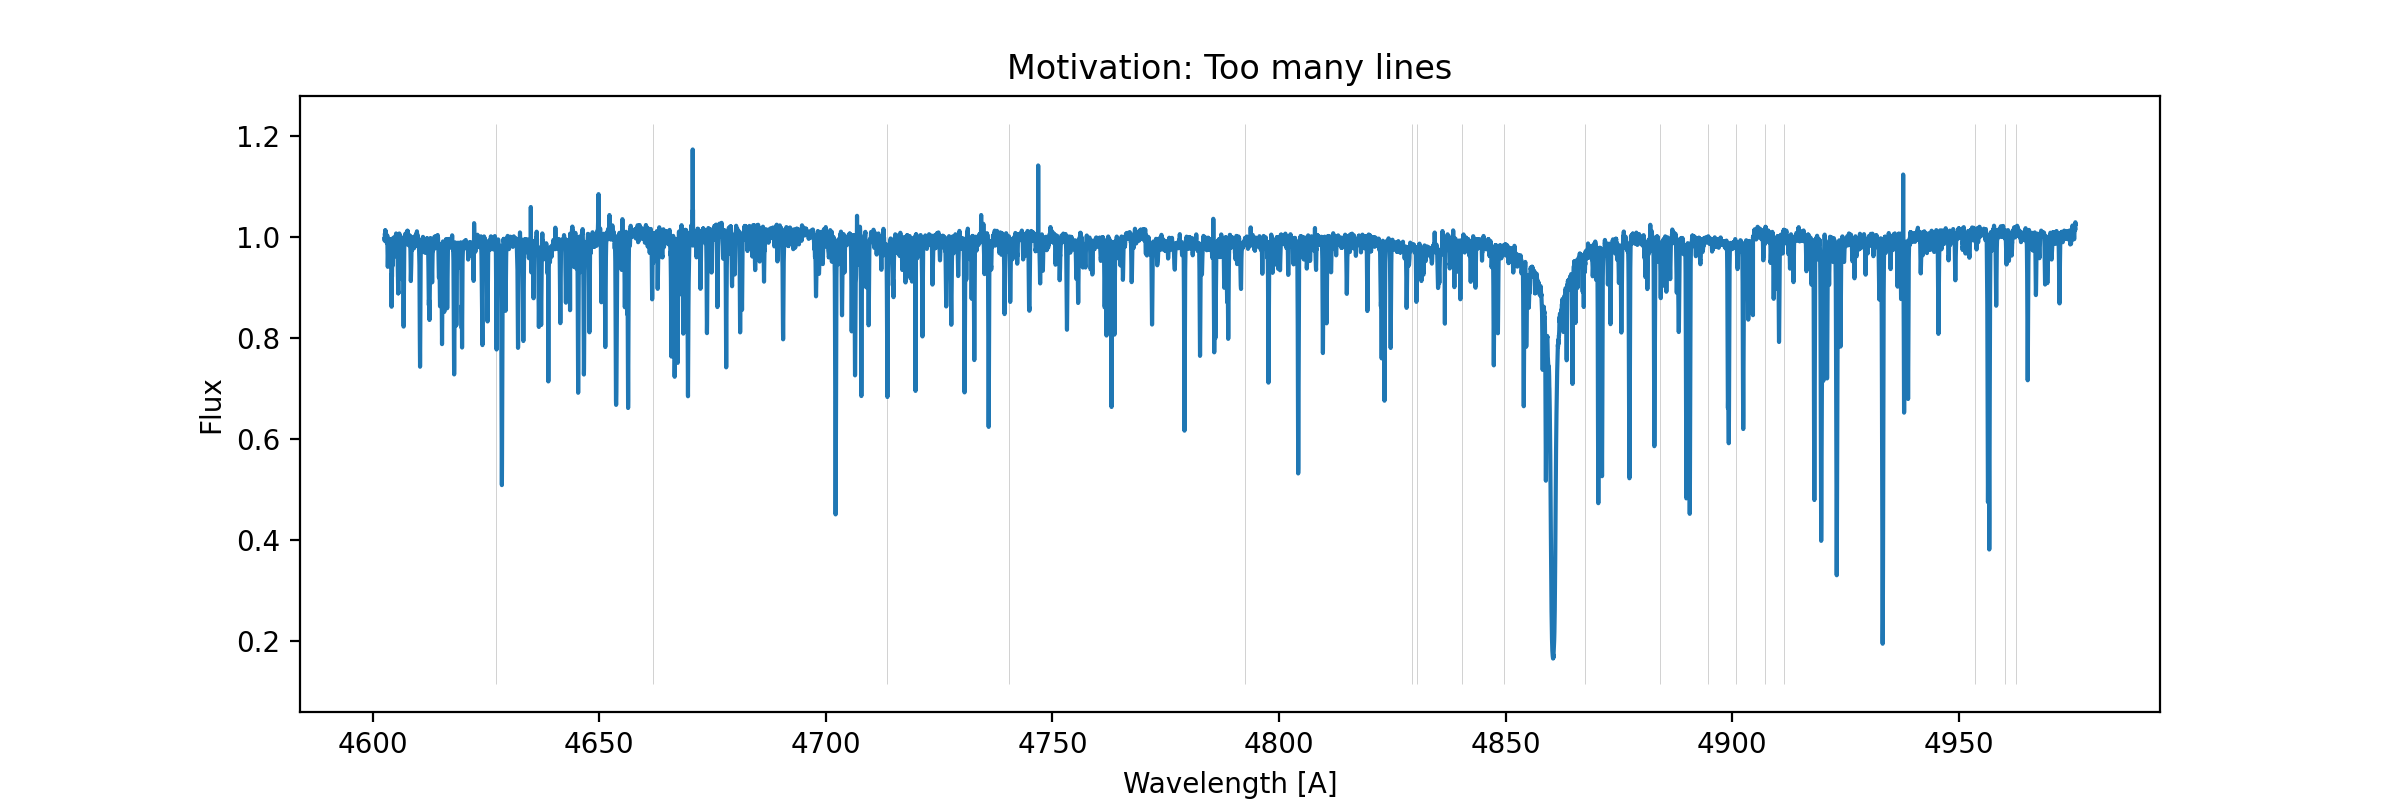

In [32]:
plt.figure(figsize=(12,4))
ax = plt.subplot(111)
plt.title('Motivation: Too many lines')

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

plt.plot(w , f )

ymin, ymax = ax.get_ylim()
for ll_w in ll_waves:
    plt.vlines( ll_w, ymin, ymax, color='grey', linewidth=0.25, alpha=0.5, zorder=0 )

___

# Step 1: Reduce the full line list <a id='step1'></a>

We can begin to reduce the line list by identifying regions in the spectrum where there are lines. 
Any lines in the full line list which do not fall in one of these regions can be discarded.   

### Step 1.1: Identify Peaks

Spectral lines appear as peaks in the (invereted) flux data.  We can begin to identify regions of the spectrum where there are lines by identifing the locations of peaks in the data.  The scipy.signal functions `find_peaks` seems to do an excellent job of this. 

- minimumDepth is the minimum depth a spectral line can be (measured from 1) and still be idenified as a peak.  The minimum depth and help ensure that noise is not identified as a peak. 
    - A smaller minimum depth will allow for more peaks to be identified
    - A higher minimum depth will result in only strong lines being identified as peaks
    - If you do not want to restrict how deep a spectral line can be, you can set `minimumDepth=0`


- maximumDepth is the maximum depth a spectral line can be (measured from 1)  and still be idenified as a peak.
    - A smaller maxiumum depth will result in only weaker lines being identified
    - A higher minimum depth will result more lines being idenified.  
    - If you do not want to restrict how deep a spectral line can be, you can set `maximumDepth=None`



*Optional*  
Smooth the data, you can apply a smoothing function to remove some of the peaks from the data, then run the peak finding function.  You can use this as a way to choose the strenght of the peaks you wish to keep. 

- For example, a small smoothing filter will remove some of the noise and prevent it from being identified as peaks, but will leave most of the actual lines. 
- For example, a strong smoothing filter will remove most of the weak and mid-strength peaks, but will leave most of the strong lines. 
        
This another way you can fine tune your peak selection in addition to the parameters in find_peaks


In [33]:
minimumDepth = 0.05 # Change Me. A lower minimum depth will mean more peaks are identified
maximumDepth = None # Change Me. A small maximum depth will select only weak lines
prominence = 0.05 # Change Me. A lower prominince will mean more peaks are ientified  

In [34]:
# --------------- Optional Smooth the spectrum
# Comment this out or skip this section if you don't want to smooth

# order = 3           # Change Me
# window_length = 31   # Change Me
# f =  savgol_filter(f, window_length, order)

In [35]:
ind_minima = find_peaks(-f+1,height=(minimumDepth, maximumDepth), prominence=prominence )[0]
print('Found {} peaks '.format(len(ind_minima)))

Found 243 peaks 


<IPython.core.display.Javascript object>


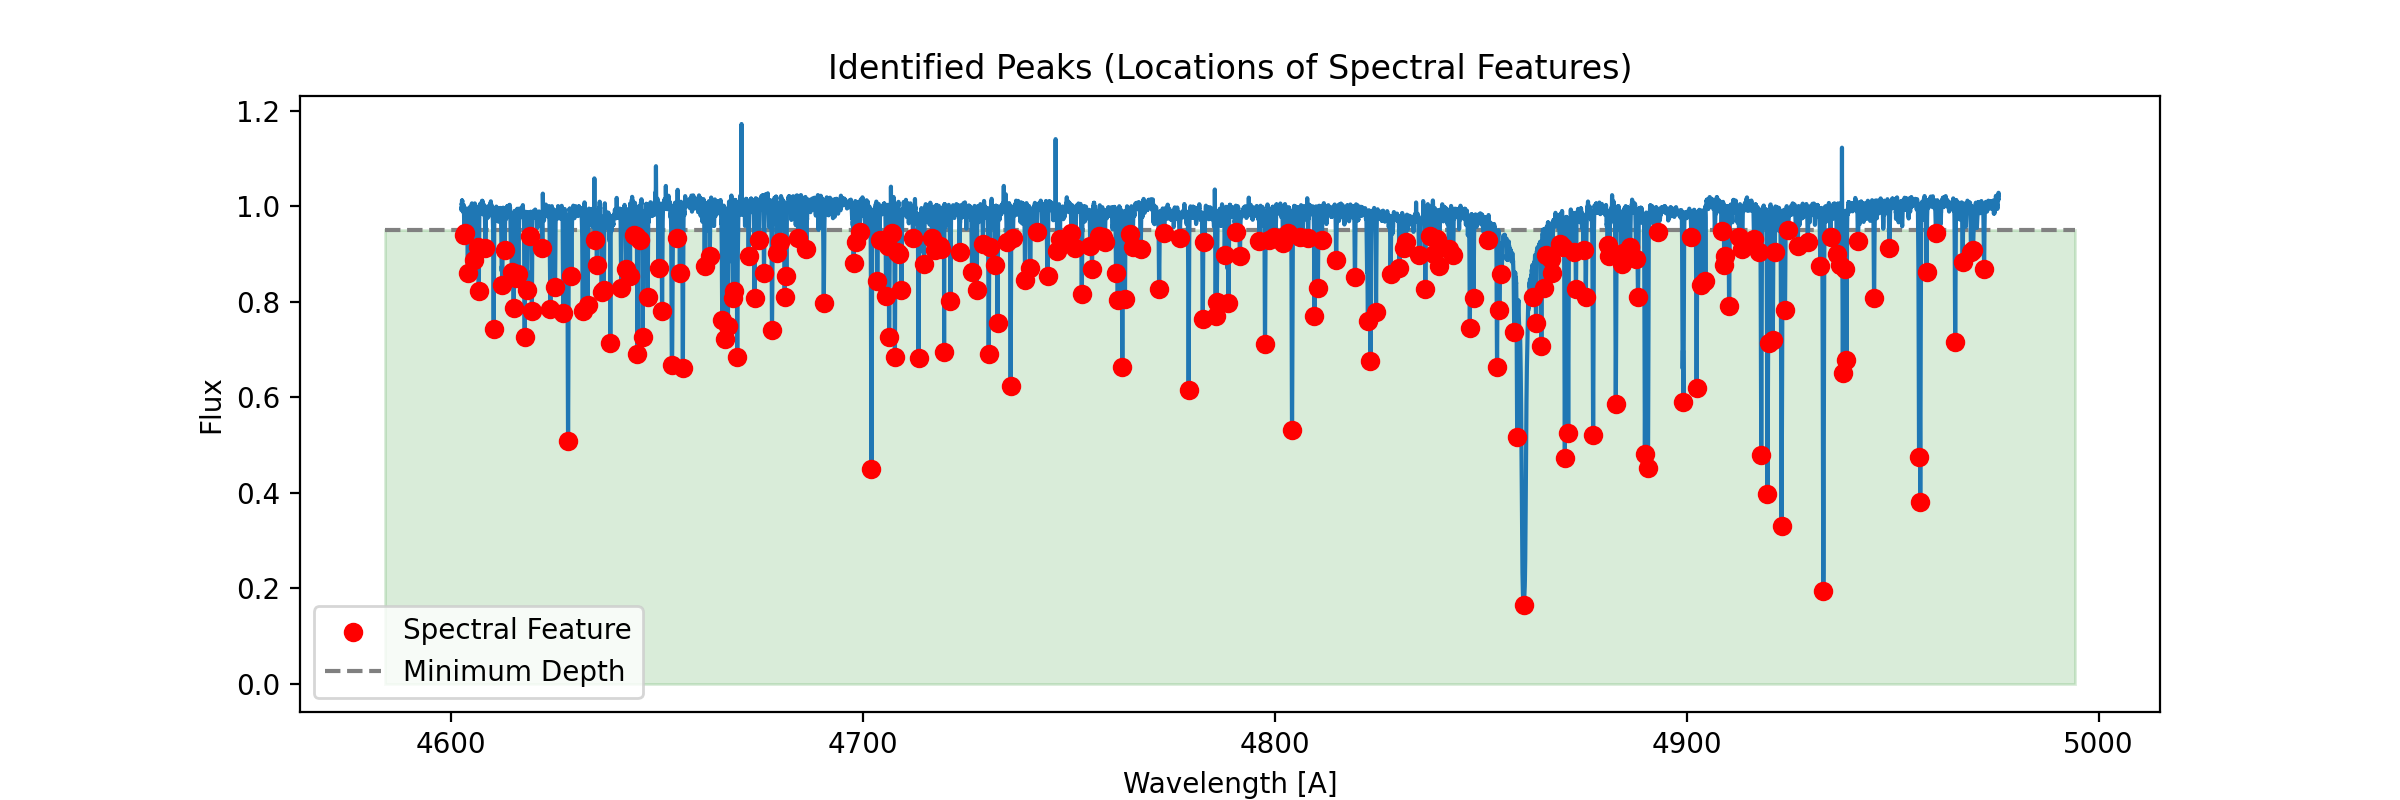

In [36]:
plt.figure(figsize=(12,4))

ax1  = plt.subplot(111)
plt.title('Identified Peaks (Locations of Spectral Features)')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.plot(w, f,zorder=2)

plt.scatter( w[ind_minima], f[ind_minima] , color='red', label='Spectral Feature',zorder=3)


xmin, xmax = ax1.get_xlim()
if minimumDepth != None:
    plt.hlines( 1- minimumDepth, xmin, xmax, linestyle='--', zorder=1, color='grey', alpha=1, label='Minimum Depth' )
if maximumDepth != None:
    plt.hlines( 1- maximumDepth, xmin, xmax, linestyle='-.', zorder=1, color='grey', alpha=1, label='Maximum Depth' )

if minimumDepth != None and maximumDepth == None:
    rect = patches.Rectangle(( xmin , 0 ), xmax-xmin, 1-minimumDepth , linewidth=1, edgecolor='green', facecolor='green', alpha=0.15, zorder=0)
    ax1.add_patch(rect) 
    
if minimumDepth != None and maximumDepth != None:
    rect = patches.Rectangle(( xmin , 1-maximumDepth ), xmax-xmin, maximumDepth-minimumDepth , linewidth=1, edgecolor='green', facecolor='green', alpha=0.15, zorder=0)
    ax1.add_patch(rect)


plt.legend()

___
### Step 1.2:   Extract lines from full line list from specified regions


**Specify a search window**

Now that we have identified the peaks in the data and have a general sense of where there are spectral lines in the data, we must identify lines in the full line list which are near these locations. 

To do this we specify a window size.  Any lines in the full line list which fall within the specified window around the peak will be kept.   

- The code will keep lines from the full line list which fall within +/- the window size centered on each peak. Therefore, a good window size to start with is *half* the FWHM of a typical line in your spectrum.
- If you suspect your lines may have significant blending, you will want to select a larger window size. 
- If you suspect your lines are isolated, you can select a smaller window size. 



In [37]:
# ---------------  Specify the width in angstroms around the peaks within which you wish to extract lines 
window = 0.05 # Change Me.  A larger window will mean more lines are included in the reduced line list

<IPython.core.display.Javascript object>


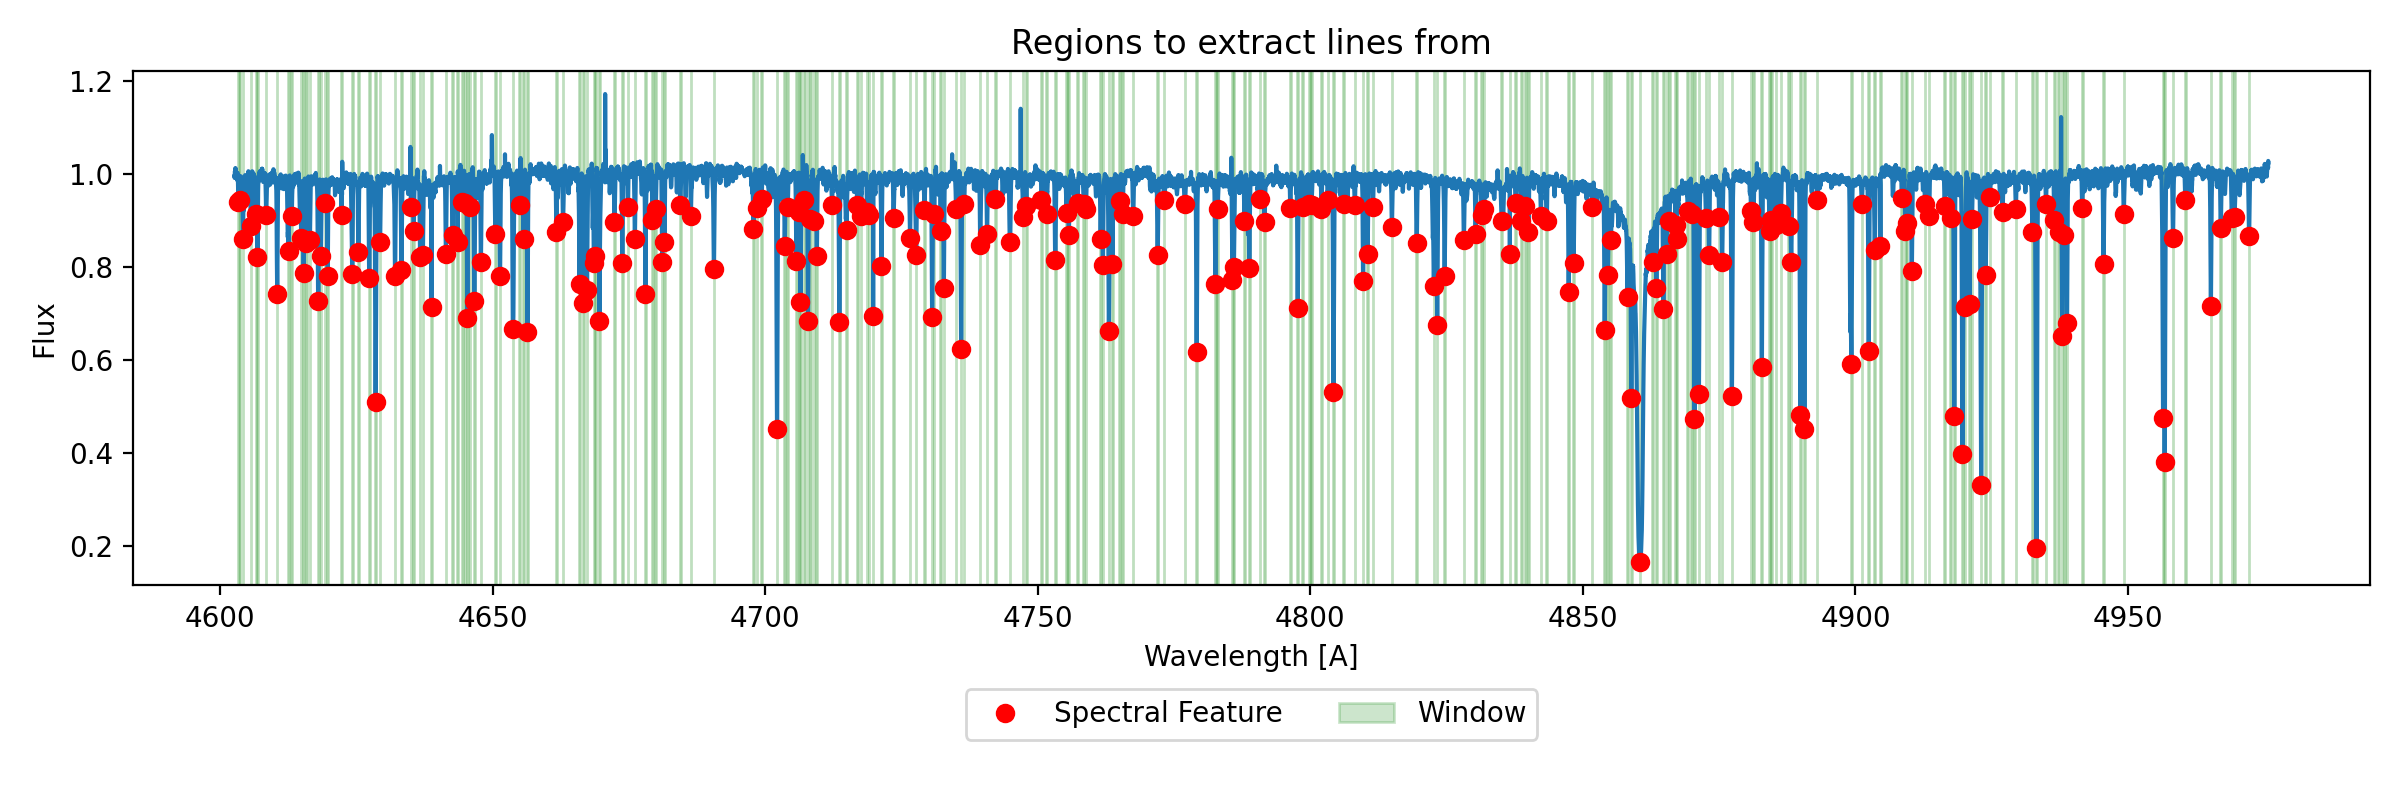

In [38]:
plt.figure(figsize=(12,4))

ax1  = plt.subplot(111)

plt.title('Regions to extract lines from')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

plt.plot(w, f, zorder=1)

plt.scatter( w[ind_minima], f[ind_minima] , color='red', label='Peaks', zorder=2)


ymin, ymax = ax1.get_ylim()
for wi in w[ind_minima]:   
    rect = patches.Rectangle(( wi-window , ymin ), window*2, ymax, linewidth=1, edgecolor='green', facecolor='green', alpha=0.25, zorder=0)
    ax1.add_patch(rect)

    
    
# ---------------------------------------  
legend_elements = [Line2D([0], [0], marker='o', color='red', linewidth=0, alpha=1, label='Spectral Feature'),
                   Patch(facecolor='green', edgecolor='green', alpha=0.2, label='Window') ]
plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.3), ncol=3, loc='lower center', borderaxespad=0.)

plt.tight_layout()

Note:  Any lines from the full line list which fall wihin a green rectangle will be kept.  Everything else will be discarded.  
- Therefore, more green rectangles OR wider green rectangles  = potentially more lines in the final line list

**In each windowed region, extract lines from the large linelist**

("windowed region" = green rectangle in the above plot)

In [39]:
unidentifiedFeatures = np.array(['# Window = {} angstroms'.format(window) ])
options = np.array([])

for ind in ind_minima:
    
    # Find all the lines in the line list within a window around this line 
    ll_ind = np.where( ( ll_waves >= w[ind] - window) & ( ll_waves <= w[ind] + window)    )[0]
    
    
    # If there are lines withinin the window
    if len(ll_ind) > 0:
        # Append to new line list 
        options = np.concatenate( ( options, ll[ll_ind])  )
        
    # If there are no lines within the window, this will be called an "unidentifed feature"
    if len(ll_ind) == 0:
        unidentifiedFeatures = np.concatenate( (unidentifiedFeatures,  [w[ind]]  ) )

**Collate those smaller linelists into one linelist**

In [42]:
options_waves = [ float(item.split()[0]) for item in options ]

options_dict = { options_waves[i]:options[i] for i in range(len(options)) }

reducedList = list(options_dict.values())

print('Found {} lines'.format(len(reducedList)))


Found 2 lines


**Visualize the Reduced List**  
Let's re-do the plot from above where a vertical line was plotted everywhere there is a line in the line list 

<IPython.core.display.Javascript object>


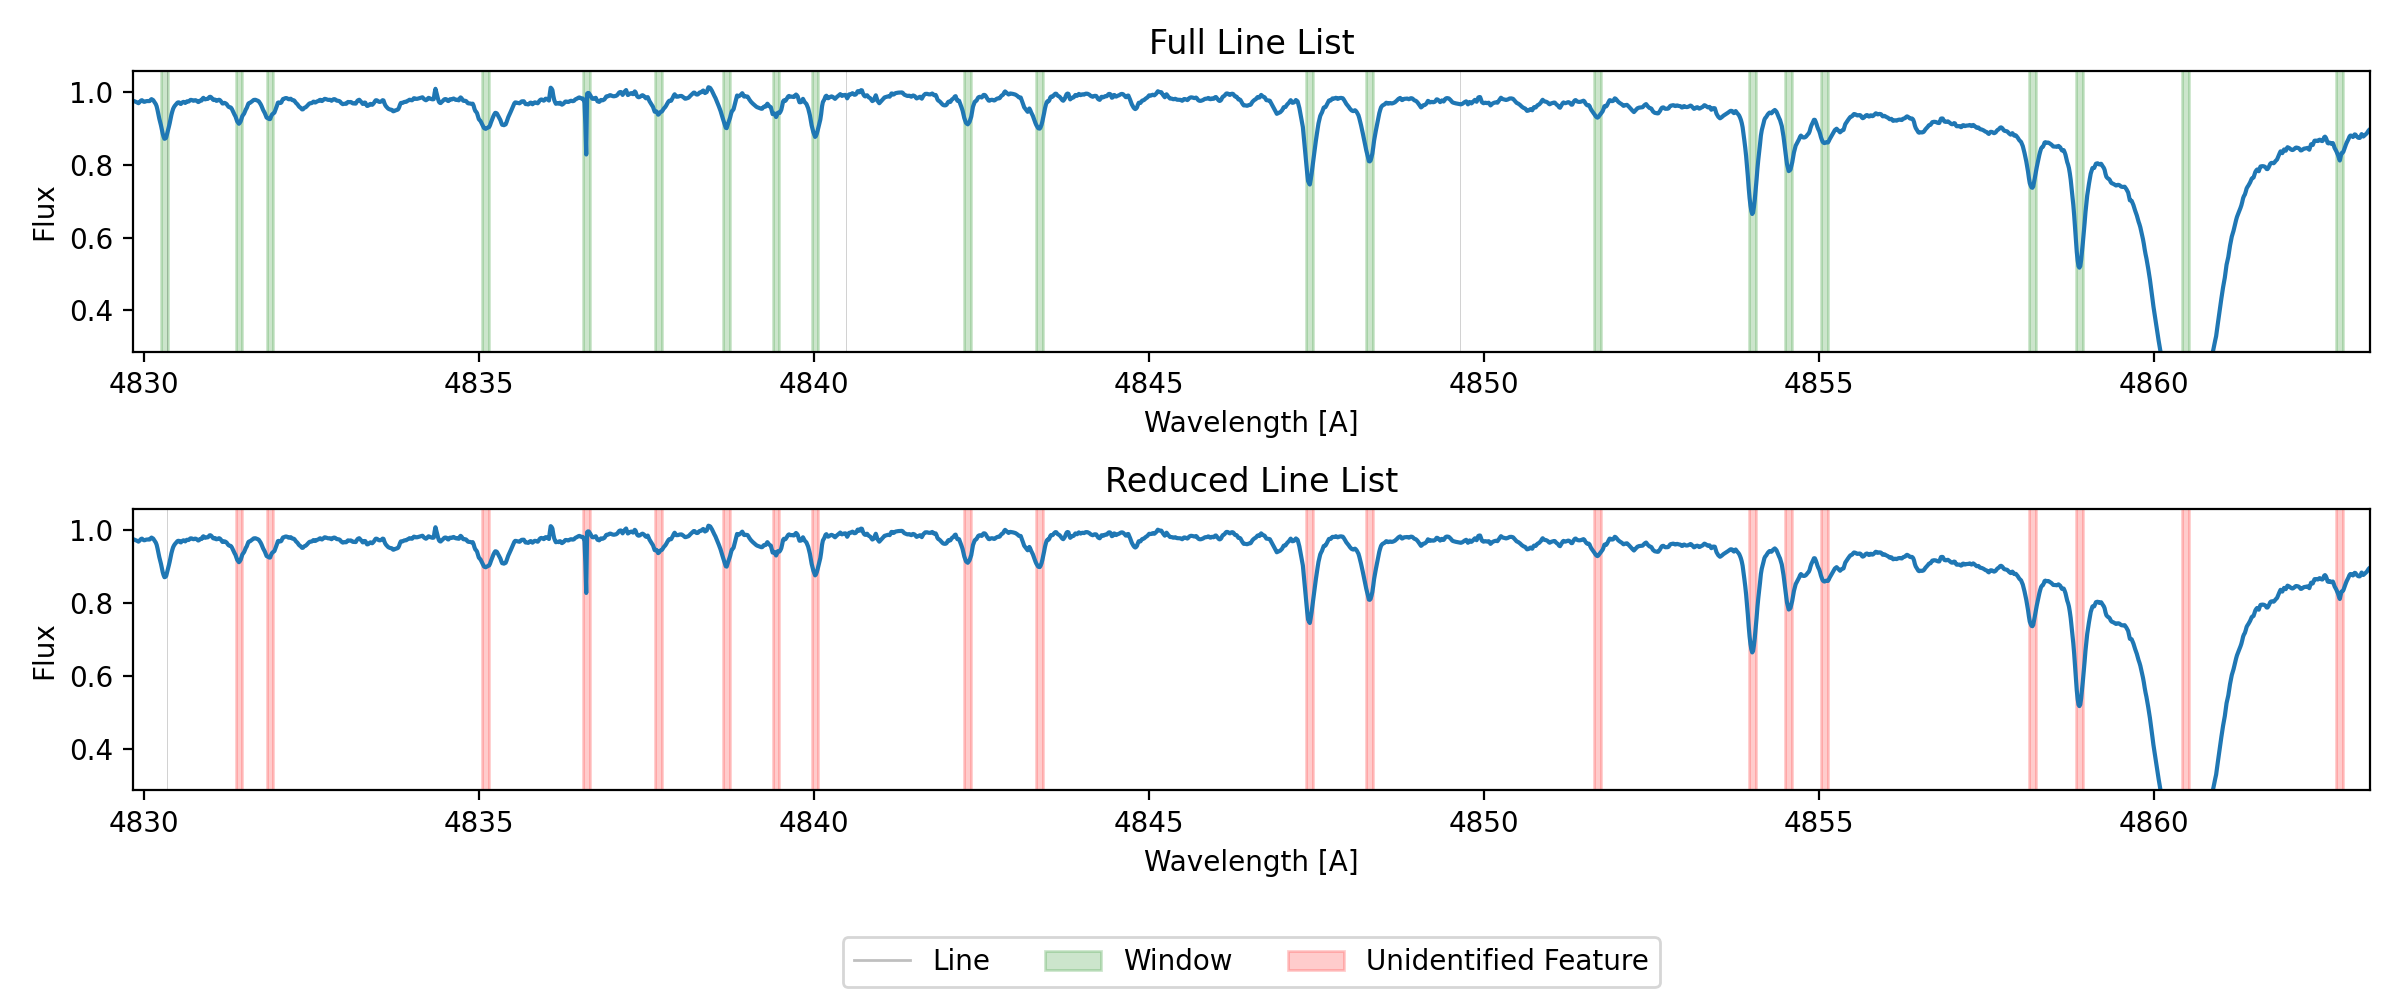

In [44]:
plt.figure(figsize=(12,5))

ax1 = plt.subplot(211)
plt.title('Full Line List')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

plt.plot(w , f )

ymin, ymax = ax1.get_ylim()
ax1.set_ylim(ymin,ymax)

for ll_w in ll_waves:
    plt.vlines( ll_w, ymin, ymax, color='grey', linewidth=0.25, alpha=0.5, zorder=1 )
    
for wi in w[ind_minima]:   
    rect = patches.Rectangle(( wi-window , ymin ), window*2, ymax, linewidth=1, edgecolor='green', facecolor='green', alpha=0.2, zorder=0)
    ax1.add_patch(rect)
    
# ---------------------------------------
ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
plt.title('Reduced Line List')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.plot(w, f)

for ll_w in options_waves:
    plt.vlines( ll_w, ymin, ymax, color='grey', linewidth=0.25, alpha=0.5, zorder=1 )

for ll_w in unidentifiedFeatures[1:]:
    rect = patches.Rectangle(( float(ll_w)-window , ymin ), window*2, ymax, linewidth=1, edgecolor='red', facecolor='red', alpha=0.2, zorder=0)
    ax2.add_patch(rect)


# ---------------------------------------  
plt.subplots_adjust(hspace=1)
legend_elements = [Line2D([0], [0], color='grey', lw=1, alpha=0.5, label='Line'),
                   Patch(facecolor='green', edgecolor='green', alpha=0.2, label='Window'), 
                  Patch(facecolor='red', edgecolor='red', alpha=0.2, label='Unidentified Feature')]
plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.7), ncol=3, loc='lower center', borderaxespad=0.)

plt.tight_layout()

**Recap**

In [45]:
print('- {} lines in the provided full line list\n'.format(init_len))
print('- {} lines in the full line list within the spectral range\n'.format(len(ll)))
print('- {} lines in the reduced line list \n '.format(len(reducedList)))
print('- {} of the observed and flagged spectral features were found to have no candiates lines\n'.format(len(unidentifiedFeatures[1:])))

- 20 lines in the provided full line list

- 18 lines in the full line list within the spectral range

- 2 lines in the reduced line list 
 
- 241 of the observed and flagged spectral features were found to have no candiates lines



*What to do with unidentfied features?*  

"Unidentified features" are spectral features which do not have any candidate lines.  This means that no lines in the master line list fell within the specified window around the feature.  This could happen for a number / combination of reasons.  For example, 
1. Your window may have been too narrow. For example, your spectral feature may be a blend and the contributing lines happen to fall just outside of the window.
2. Your wavelength solution and/or radial velocity correction may have been wrong. Meaning the contributing line(s) are in the master list but happened to fall outside the window do to the feature being assigned an incorrect wavelength.
3. There simply isn't lines in the master list for that feature (this is the most interesting option)

4. Telluric lines ???

Carefully inspect the above plot to see options 1. or 2. are likely. 

**Save reduced line list and list of unidentified features**  
If you are happy with this, you can save the reduced line list

In [28]:
np.savetxt( '{}_reducedList.txt'.format(name),[ line.strip('\n') for line in reducedList ],  fmt='%s' )
print('Saving reduced list to '+os.getcwd()+'/{}_reducedList.txt'.format(name)  )


np.savetxt( '{}_unidentifiedFeatures.txt'.format(name),unidentifiedFeatures,  fmt='%s' )
print('Saving list of unidentified features to '+os.getcwd()+ '/{}_unidentifiedFeatures.txt'.format(name)  )

Saving reduced list to /arc5/home/jglover/ASAP/HD222925Blue_reducedList.txt
Saving list of unidentified features to /arc5/home/jglover/ASAP/HD222925Blue_unidentifiedFeatures.txt


(Note: you do not have to do the next step, if you are happy with the line list found in step 1 you can stop here)

___

# Step 2: Further reduce the line list with Moog <a id='step2'></a>

We can now use moog on the reduced line list in order to identify which lines make a significant contribution to the observed spectrum.  This will reduce the reduced line list even further. 


### Step 2.1: Generate a model atmosphere

In order to run moog on the spectrum, we need to generate a model atmosphere.  Other than influencing the synthetic spectra generated by moog, this doesn't have any influence on the final reduced line list 

In [29]:
# Paths to places

# Where we are now and want to work
working_path = os.getcwd() + '/'

# Path to the spectra
spec_path = dataDir+'/final_spectra/'

# Path to send the MOOG output files
synth_out_path = os.path.join( dataDir , 'synthetic/')

In [30]:
# Define the model atmosphere name
model_in = name + '.mmod'

# Generate a MARCS model atmosphere and place it in the current working directory

aa.gen_mod_atm(name, params, working_path, print_params=True)

-----------------------------------------------------------------
----------------- Generating a Model Atmosphere -----------------
-----------------------------------------------------------------

----------------- Finding model atmosphere parameters:
-The model atmosphere parameters are: 
['5636 2.54 -1.5 1.83 HD222925Blue']
-Saving model atmosphere parameters to: params.txt 
-Saving atoms to: atoms.txt


----------------- Finding which group of model atmosphere grids to use based on the log g coverage:
-/arc5/home/jglover/ASAP/asap_lib/data/grids/standard/sphere/


----------------- Creating the model atmospheres:
-Reading params.txt
-Grid coverage for models in /arc5/home/jglover/ASAP/asap_lib/data/grids/standard/sphere/:
Temperature range: 3800.0 K - 7500.0 K
Gravity range: 0.0 - 3.5
Metallicity range: -5.0 - 1.0
(Though your stellar parameters may be within the grid boundaries, local gaps may cause problems. Tread carefully.)

------- Starting Model Atmosphere Creation for Star 

gv: Unable to open the display.


### Step 2.2: Run moog on the reduced line list 

The moog looper function will identify lines which are upper limits and remove them from the line list.  This will further reduce the list to only lines which make a significant contribution to the observed spectrum.  

In [31]:
# Path to the linelists
full_list_path = working_path 
print(full_list_path)

line_list = name+'_reducedList.txt' 
# line_list = name+'_reducedSmoothedList.txt' 
print(line_list)

# Create a dictionary for the linelist
line_dict = mf.lines_2_dict(line_list, params)

/arc5/home/jglover/ASAP/
HD222925Blue_reducedList.txt


In [32]:
# ----- Threshold
# The minimum of a generated synthetic spectrum for the given line must be within (threshold*100) percent
# of the corresponding location in the observed spectrum to be kept
threshold = 0.3 # Change me

# ----- Smoothing factors for the Gaussian smoothing kernel in angstroms
# Start with some first guess smoothing parameter for MOOG. This can be refined later.
smogs = [0.15] # Change me 

# ----- Test abdundances
# Generate an array of test abundances to get a quick metallicity estimate
# Note:  Choose a large range of test abundances (large difference in test abundance values is A-okay)
test_abunds = np.linspace(-4.0, 4.0, 20) # Change me 


# ----- Folder to save moog plots to
# Unlike the typical versions of moog_looper, all plots will be saved and not displayed in the notebook
folder = name+'_findlines_plots'

# If the subfolder does not exist, make it
exists = os.path.isdir(folder)
if not exists:
    os.mkdir(folder)

# ----- kwargs for findlines_mooglooper
kwargs = {  
'spec_name':name, 
'spectrum':spectrum, 
'model_atm':model_in,
'threshold': threshold,
'smogs': smogs, 
'abundances': test_abunds,
'retrim':True,
'trim_sigma':[5.0, 1.2],
'ul_sigma':3.0,
'correct_rv':False,              
'print_prog':False, 
'plots':True, 
'savefolder':'/arc5/home/jglover/ASAP/'+folder}

**Run findlines_mooglooper with multiprocessing**

In [33]:
st = time.time()
rslt = mf.findlines_multiprocess_driver(line_dict, kwargs)
en = time.time()

print('Total time {:.3f} seconds'.format(en - st))

sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
sh: \rm: command not found
s

Total time 3.249 seconds


**Visualize the Moog Reduced List**  
Let's re-do the plot from above where a vertical line was plotted everywhere there is a line in the line list 

<IPython.core.display.Javascript object>


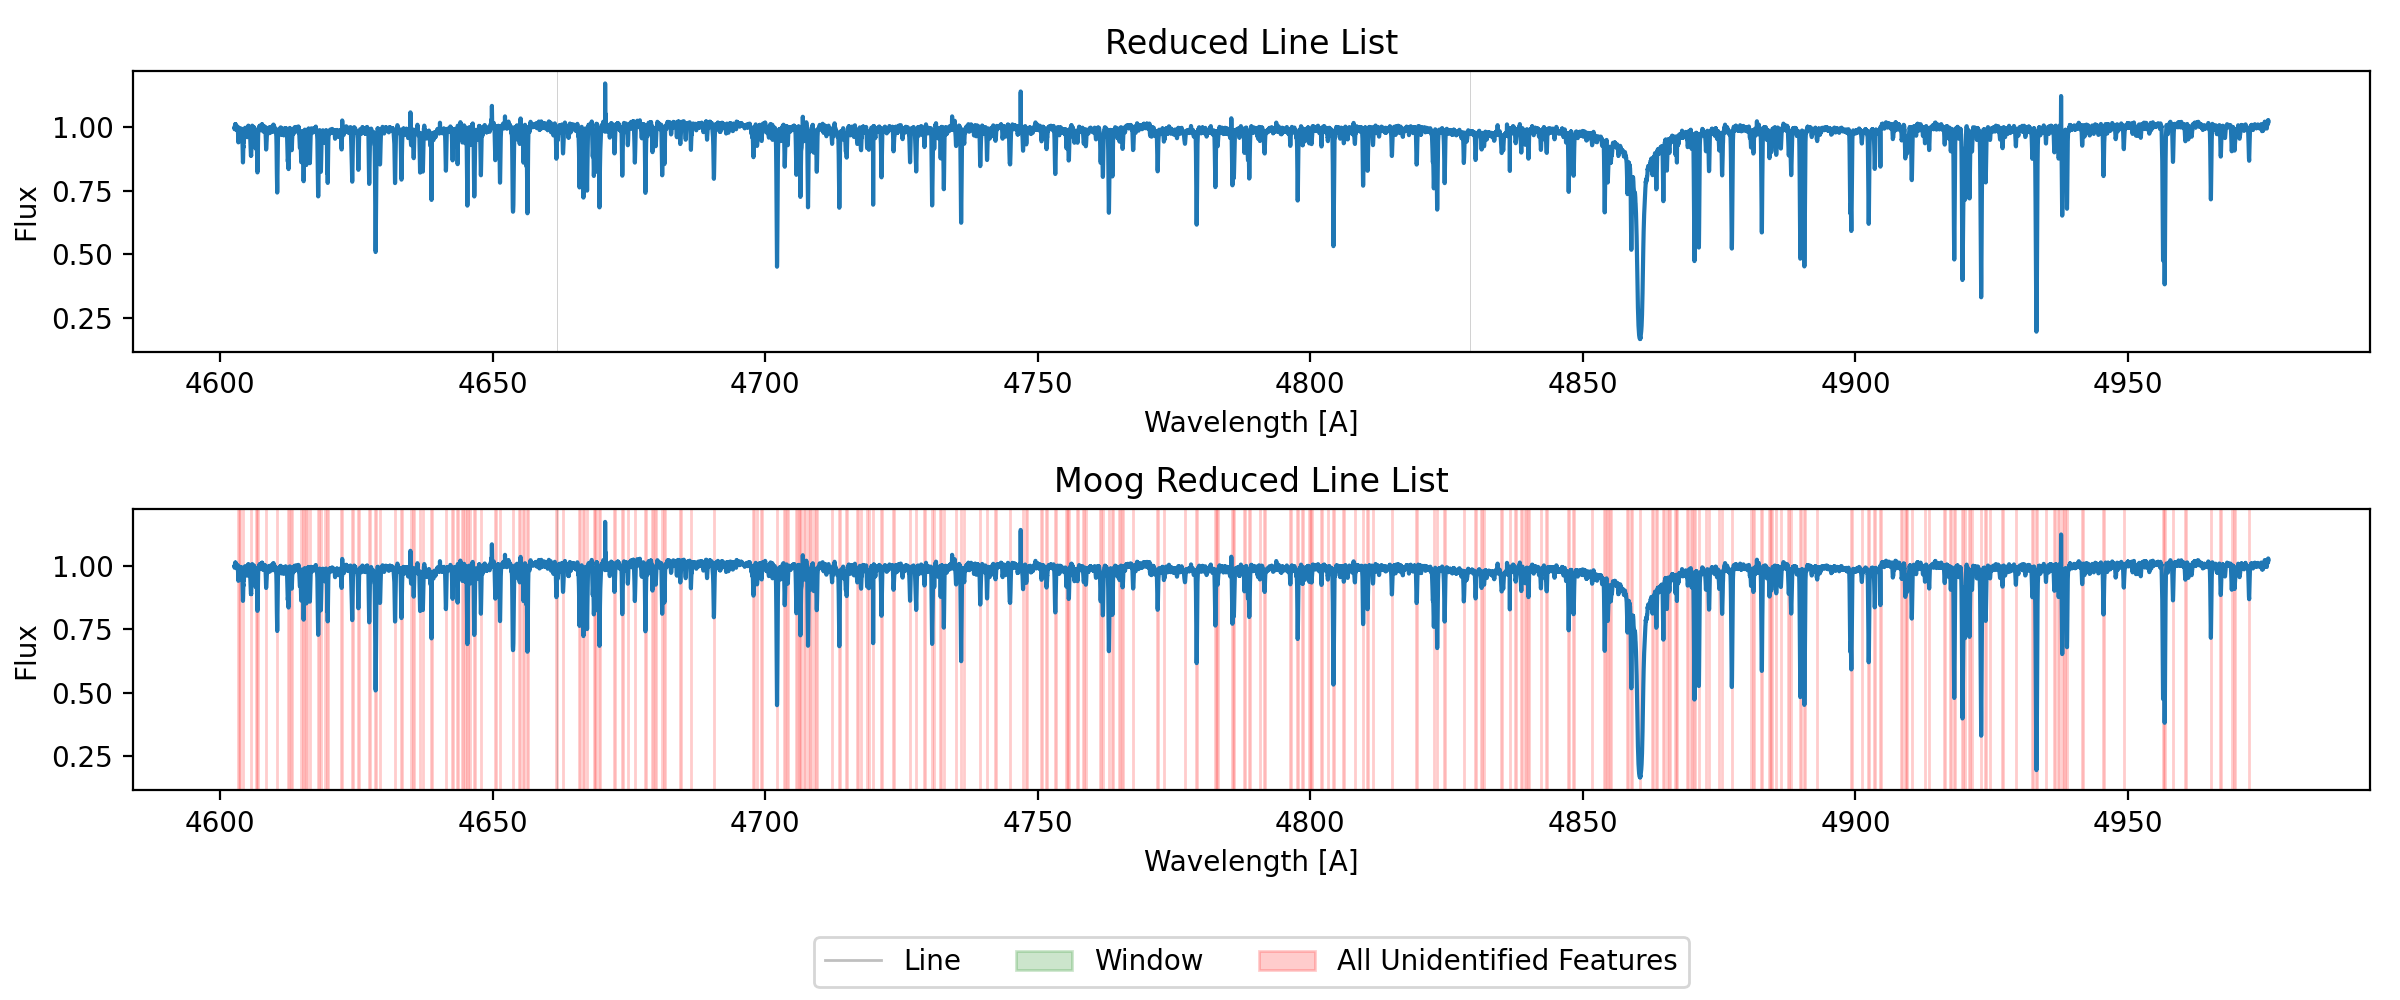

In [34]:
plt.figure(figsize=(12,5))

ax1 = plt.subplot(211)
plt.title('Reduced Line List')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

plt.plot(w , f )

ymin, ymax = ax1.get_ylim()
ax1.set_ylim(ymin,ymax)

for ll_w in options_waves:
    plt.vlines( ll_w, ymin, ymax, color='grey', linewidth=0.25, alpha=0.5, zorder=1 )

    
# ---------------------------------------
ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
plt.title('Moog Reduced Line List')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.plot(w, f)

for ll_w in list(rslt.keys()):
    plt.vlines( ll_w, ymin, ymax, color='grey', linewidth=0.25, alpha=0.5, zorder=1 )

moogUnidentifiedFeatures = ['# Window = {} angstroms'.format(window) ]
hldr = np.array(list(rslt.keys()))
for ind in ind_minima:
    i = np.where( ( hldr >= w[ind] - window ) & ( hldr <= w[ind] + window) )[0]
    if len(i) == 0:
        moogUnidentifiedFeatures.append( w[ind] ) 
        rect = patches.Rectangle(( w[ind]-window , ymin ), window*2, ymax, linewidth=1, edgecolor='red', facecolor='red', alpha=0.2, zorder=0)
        ax2.add_patch(rect)

    
# ---------------------------------------  
plt.subplots_adjust(hspace=1)
legend_elements = [Line2D([0], [0], color='grey', lw=1, alpha=0.5, label='Line'),
                   Patch(facecolor='green', edgecolor='green', alpha=0.2, label='Window'), 
                  Patch(facecolor='red', edgecolor='red', alpha=0.2, label='All Unidentified Features')]
plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.7), ncol=3, loc='lower center', borderaxespad=0.)

plt.tight_layout()


**Recap**

In [35]:
print('------- Features')
print('- {} lines in the provided full line list\n'.format(init_len))
print('- {} lines in the full line list within the spectral range\n'.format(len(ll)))
print('- {} lines in the reduced line list\n'.format(len(reducedList)))
print('- {} lines in the moog reduced line list (this is the final list)\n'.format(len(rslt.keys())))


print('------- Unidentified Features')
print('- {} of the observed and flagged spectral features were found to have no candiates lines\n'.format(len(unidentifiedFeatures[1:])))
print('- {} of the features with candidate lines were rejected by moog\n'.format(len(moogUnidentifiedFeatures[1:]) - len(unidentifiedFeatures[1:]) ))
print('- {} of the osberved spectral features were unidentified in total'.format(len(moogUnidentifiedFeatures[1:]) ))

------- Features
- 21 lines in the provided full line list

- 21 lines in the full line list within the spectral range

- 2 lines in the reduced line list

- 1 lines in the moog reduced line list (this is the final list)

------- Unidentified Features
- 241 of the observed and flagged spectral features were found to have no candiates lines

- 2 of the features with candidate lines were rejected by moog

- 243 of the osberved spectral features were unidentified in total


*What to do with Moog unidentfied features?*  

"Moog Unidentified features" are spectral features which had candidate spectral line(s) but Moog rejected all of them.
 This means that none of the candidate lines for the spectral feature were determined by Moog to have significant effect on the observed spectrum.  This could happen for a number / combination of reasons.  For example, 

1. Your selection criteria (the 'threshold' parameter) was too small.  Meaning, line(s) which contribute to the observed spectrum were passed to Moog and Moog was able to generate synthetic spectra using these line(s) but they were rejected for not being similar enough to the observed feature.
2. Your test abundance range was too small or you did not take enough test abundances.  Meaning, line(s) which contribute to the observed spectrum were passed to Moog and Moog was able to generate synthetic spectra using these line(s) but they were rejected for not being similar enough to the observed feature.

In addition, these may also be contributing factors still:  

3. Your window may have been too narrow. For example, your spectral feature may be a blend and the contributing lines happen to fall just outside of the window.   
4. Your wavelength solution and/or radial velocity correction may have been wrong. Meaning the contributing line(s) are in the master list but happened to fall outside the window do to the feature being assigned an incorrect wavelength.  
5. There simply isn't lines in the master list for that feature (this is the most interesting option)  
6. Telluric lines ???

Carefully inspect the plots produced by Moog to see options 1. or 2. are likely.  If they are likley, try increasing the threshold parameter and using more test abundances over a larger range.  If they are not likley, go back to Step 1 and readjust your parameters (ex. try a larger window size).  

**Save Reduced Line Lists**  
If you are happy with this, you can save the reduced line list

In [36]:
llu.dict_2_linelist(rslt,name+'_moogReducedList.txt' )
print('Saving reduced list to '+os.getcwd()+'/{}_moogReducedList.txt'.format(name)  )

np.savetxt( '{}_moogUnidentifiedFeatures.txt'.format(name),moogUnidentifiedFeatures,  fmt='%s' )
print('Saving full list of unidentified features to '+os.getcwd()+ '/{}_moogUnidentifiedFeatures.txt'.format(name)  ) 

Saving reduced list to /arc5/home/jglover/ASAP/HD222925Blue_moogReducedList.txt
Saving full list of unidentified features to /arc5/home/jglover/ASAP/HD222925Blue_moogUnidentifiedFeatures.txt


___

**Clean Up**

In [58]:
# Delete the model atmosphere file and the master line list copy 
deleteFiles = [name + '.mmod', file ]

_ = [os.remove(filename) for filename in deleteFiles if os.path.exists(filename)]

---
# (Optional)  Step 3: Further Customize Your List <a id='step3'></a>

If you want you can further customize the line list you generated.


### Remove lines by wavelength 
Remove specific lines from your line list using their wavelength

In [ ]:
# Option 1: List them here: (ex [xxxx.x, yyyy.y, zzzz.z, ... ])
# remove_lines = [  ]

# Option 2: List them in a file called remove_lines.txt
# remove_lines = [ float(line.strip()) for line in open('remove_lines.txt').readlines()]

# line_list = name+'_moogReducedList.txt'
# llu.trim_lines_from_list(line_list, remove_lines)

### Remove lines by species
Remove all lines from your list which correspond to a specific species

In [ ]:
# ---------- Optional: Trim out specific species 
# For example, if you don't want any iron lines, use [26.0, 26.1]

# line_list = name+'_moogReducedList.txt'
# llu.trim_species_from_list( line_list, [] )

___
# (Optional) Compare Line Lists <a id='comparelinelists'></a>

You may wish to compare the line list you just generated with another line list

In [251]:
from itertools import groupby

def _all_equal(iterable):
    "Returns True if all the elements are equal to each other"
    g = groupby(iterable)
    return next(g, True) and not next(g, False)



def _lists_2_lines( l_w,  l_species,  l_ep,  l_lgf):
    """
    Helper Function to pack individual lists of wavelength, species, ep, and lgf into lines
    ----
    
    returns list of lines where each line is in the format:  'wavelength species ep lgf \n'
    """
    
    # ---------------- Raise Erros
    if len(l_w) != len(l_species) != len(l_ep) != len(lgf):
        raise ValueError("Lists must be the same length")  
       
    # ---------------- Write lines 
    lines = ['# \n']
    for i in range(len(l_w)):
        lines.append( '{:<10}{:<10}{:<10}{:} \n'.format( l_w[i], l_species[i], l_ep[i], l_lgf[i] ) )
        
    # ---------------- Remove newline from the end
    lines[-1] = lines[-1].strip('\n')
    
    return lines



def _remove_and_return(lst, remove):
    '''
    Helper function to remove items from a list according to their indices
    ---- 
    
    :param lst: (list) list of items
    :param remove: (list) list if indices to remove from lst
    
    returns lst with specified indices removed
    '''
    
    for item in sorted(remove, reverse=True):
        del lst[item]
    
    return lst



def removeLineDuplicates( lst, keep_type='lowest lgf', returnList=False, savename=False ):
    """
    Remove duplicates lines from a list
    ---- 
    Lines are considered duplicates if they have the same wavelenght.  However, the lines may have the smae wavelength 
    but have different parameters (for example, if the lines came from multiple sources they may have differnt lgf value). 
    The keep_type parameter allows you to specify which version of the duplciated line you wish to keep in the event they differ. 
    
    """
    
    # ---------------- Check remove option was valid 
    keep_types = ['lowest lgf', 'highest lgf' ]
    if keep_type not in keep_types:
        raise ValueError("Invalid sim type. Expected one of: %s" % keep_types)  
        
    # ---------------- Read lists
    if type(lst) == str:
        l_w, l_species, l_ep, l_lgf = llu.read_linelist(lst)  
        
    elif type(lst) in [list, np.array] :
        l_w, l_species, l_ep, l_lgf = lst

    # ---------------- Look for duplicates in wavelength 
    seen = []
    dupes = []
    for w in l_w:        
        if w not in seen:
            seen.append(w)
        else:
            dupes.append(w)
            
            
   # ---------------- Handle each duplicate 
    for item in dupes:
        ind = np.where(l_w == item)[0]    
        keep = None
        
        # ------- Check if the ducplicated entries are identical 
        identicalEntries  = True
        all_identical = [all_equal(np.array(l_species)[ind]), all_equal(np.array(l_ep)[ind]), all_equal(np.array(l_lgf)[ind])]
        if False in all_identical:
            identicalEntries  = False
            
        
        
        # ------- If all the entries are identical, just keep the first one
        if identicalEntries == True:
            keep = ind[0] 
        
        # ------- If all the entries are not identical, then keep one according to the preference
        if identicalEntries == False:
        
            # ------- Find which index to keep 
            if keep_type == 'lowest lgf':
                keep = ind[np.where( np.array(l_lgf)[ind] == min(np.array(l_lgf)[ind]) )[0]]

            if keep_type == 'highest lgf':
                keep = ind[np.where( np.array(l_lgf)[ind] == max(np.array(l_lgf)[ind]) )[0]]
          
            
        # ------- Remove all others
        remove = [ item for item in ind if item != keep]
        
        l_w = _remove_and_return(list(l_w), remove)
        l_species = _remove_and_return(list(l_species), remove)
        l_ep = _remove_and_return(list(l_ep), remove)
        l_lgf = _remove_and_return(list(l_lgf), remove)

        
    # ---------------- Save or Return 
    if returnList == True:
        return l_w, l_species, l_ep, l_lgf
    
    elif savename:      
        lines = _lists_2_lines(  l_w, l_species, l_ep, l_lgf )
        
        with open(savename, 'w') as f:
            print('Writing file to ' + savename)
            f.writelines(lines)


In [252]:
def reorder_linelist(line_list, saveasFile=True, saveName=None):
    """
    Reorder a line list such that the lines are in order of increasing wavelength.
    This might be useful when writing new line lists.

    :param line_list: (string or list) Path to the line list where each line has the format: "wave atom ep lgf \n"
    and the first line has the format "# \n"
    :param saveName: (None or string) If None, save the re-ordered line list under the original name, or else specify
    the name of the re-ordered line list

    """

    # ----------------- Read line list
    if type(line_list) == str:
        lst = np.array(open(line_list).readlines())
    elif type(line_list) in [list, np.array]:
        lst = line_list

    # ----------------- Get wavelength of each line in the list
    waves = []
    for line in lst:
        if line != '# \n':
            waves.append(float(line.split()[0]))
    waves = np.array(waves)

    # ----------------- Sort the wavelengths in increasing order
    new = waves.copy()
    new.sort()

    # ----------------- Get the indices of the original list in the new order
    ind = [np.where(waves == n)[0][0] for n in new]

    # ----------------- Reorder the original list (excluding the first line)
    lst = np.array(lst[1:])
    lst = list(lst[ind])

    # ----------------- Make sure each line except the last ends in '\n'
    for i in range(len(lst)):
        if lst[i][-1] != '\n':
            lst[i] += '\n'

    lst[-1] = lst[-1].strip('\n')

    # ----------------- Add back the first line
    lst = ['# \n'] + lst

    # ----------------- Save re-ordered line list
    if saveasFile:
        if saveName is None:
            with open(line_list, 'w') as f:
                print('Saving re-ordered list to ' + line_list)
                f.writelines(lst)
        else:
            with open(saveName, 'w') as f:
                print('Saving re-ordered list to ' + saveName)
                f.writelines(lst)
    else:
        return lst

In [253]:
def combineLineLists( list1, list2, duplicate_keep_type='lowest lgf', saveName=None ):
    """
    Combine two lines lists into a single list
    ---- 
    
    
    """
    
    # ---------------- Read the Individual Lists 
    l1_w, l1_species, l1_ep, l1_lgf  = llu.read_linelist(list1)
    l2_w, l2_species, l2_ep, l2_lgf  = llu.read_linelist(list2)
    
    # ---------------- Concatenate the lists 
    l_w = np.concatenate( (l1_w, l2_w)  )
    l_species = np.concatenate( (l1_species, l2_species)  )
    l_ep = np.concatenate( (l1_ep, l2_ep)  )
    l_lgf = np.concatenate( (l1_lgf, l2_lgf)  )

    # ---------------- Remove duplicates from combined list
    l_w, l_species, l_ep, l_lgf  = removeLineDuplicates( list1, keep_type=duplicate_keep_type, returnList=True)

    # ---------------- Reformat as lines ( like  ['wavelength species ep lgf \n', ...] )
    asLines = _lists_2_lines( l_w,  l_species,  l_ep,  l_lgf)
    lst = reorder_linelist(asLines, saveasFile=False)
    
    
    # --------------- Save or return 
    if saveName:
        with open(saveName, 'w') as f:
            print('Saving re-ordered list to ' + saveName)
            f.writelines(lst)
            
    else:
        # Extract the information from each line
        lwave = []
        latom = []
        lep = []
        llgf = []
        for i, l in enumerate(lst):
            split = l.split()
            try:
                lwave.append(float(split[0]))
                latom.append(float(split[1]))
                lep.append(float(split[2]))
                llgf.append(float(split[3]))
            except:
                pass
    
        return lwave, latom, lep, llgf

In [266]:
# ----------------  Read in your line list
ll_path = name+'_reducedList.txt'
ll_w,ll_species, ll_ep, ll_lgf =  llu.read_linelist(ll_path)


# ----------------  Read in the line list(s) you wish to compare with 
compare_list1 = 'asap_lib/data/linelists/isolated_other_lists/linelist_noFe_xm.txt'
compare_list2 =  'asap_lib/data/linelists/isolated_fe_lists/linelist_4600_6850_Fe_xm.txt'
ll_compare_w, ll_compare_species, ll_compare_ep, ll_compare_lgf =   combineLineLists( compare_list1, compare_list2)


# ----------------  Restrict the comparision list to the spectral range of your list
i = np.where( (ll_compare_w >= min(ll_w)) & (ll_compare_w <= max(ll_w))   )[0]

ll_compare_w = np.array(ll_compare_w)[i]
ll_compare_species = np.array(ll_compare_species)[i]
ll_compare_ep = np.array(ll_compare_ep)[i]
ll_compare_lgf = np.array(ll_compare_lgf)[i]

In [267]:
print('- {} line in the list'.format(len(ll_w)))
print('- {} line in the comparison list over the same spectral region'.format(len(ll_compare_w)))

- 641 line in the list
- 143 line in the comparison list over the same spectral region


In [269]:
inBoth = []
for wi in ll_w:
    if wi in ll_compare_w:
        inBoth.append(wi)
print('- {} lines in both'.format(len(inBoth)))


inCompare_notMine = []
for wi in ll_compare_w:
    if wi not in ll_w:
        inCompare_notMine.append(wi)
print('- {} lines in comparision and not new'.format(len(inCompare_notMine)))
        
inMine_notCompare = []
for wi in ll_w:
    if wi not in ll_compare_w:
        inMine_notCompare.append(wi)
print('- {} lines in new and not comparision'.format(len(inMine_notCompare)))

- 9 lines in both
- 134 lines in comparision and not new
- 632 lines in new and not comparision


**Visualize the Lists Side By Side**  
Let's re-do the plot from above where a vertical line was plotted everywhere there is a line in the line list 

<IPython.core.display.Javascript object>


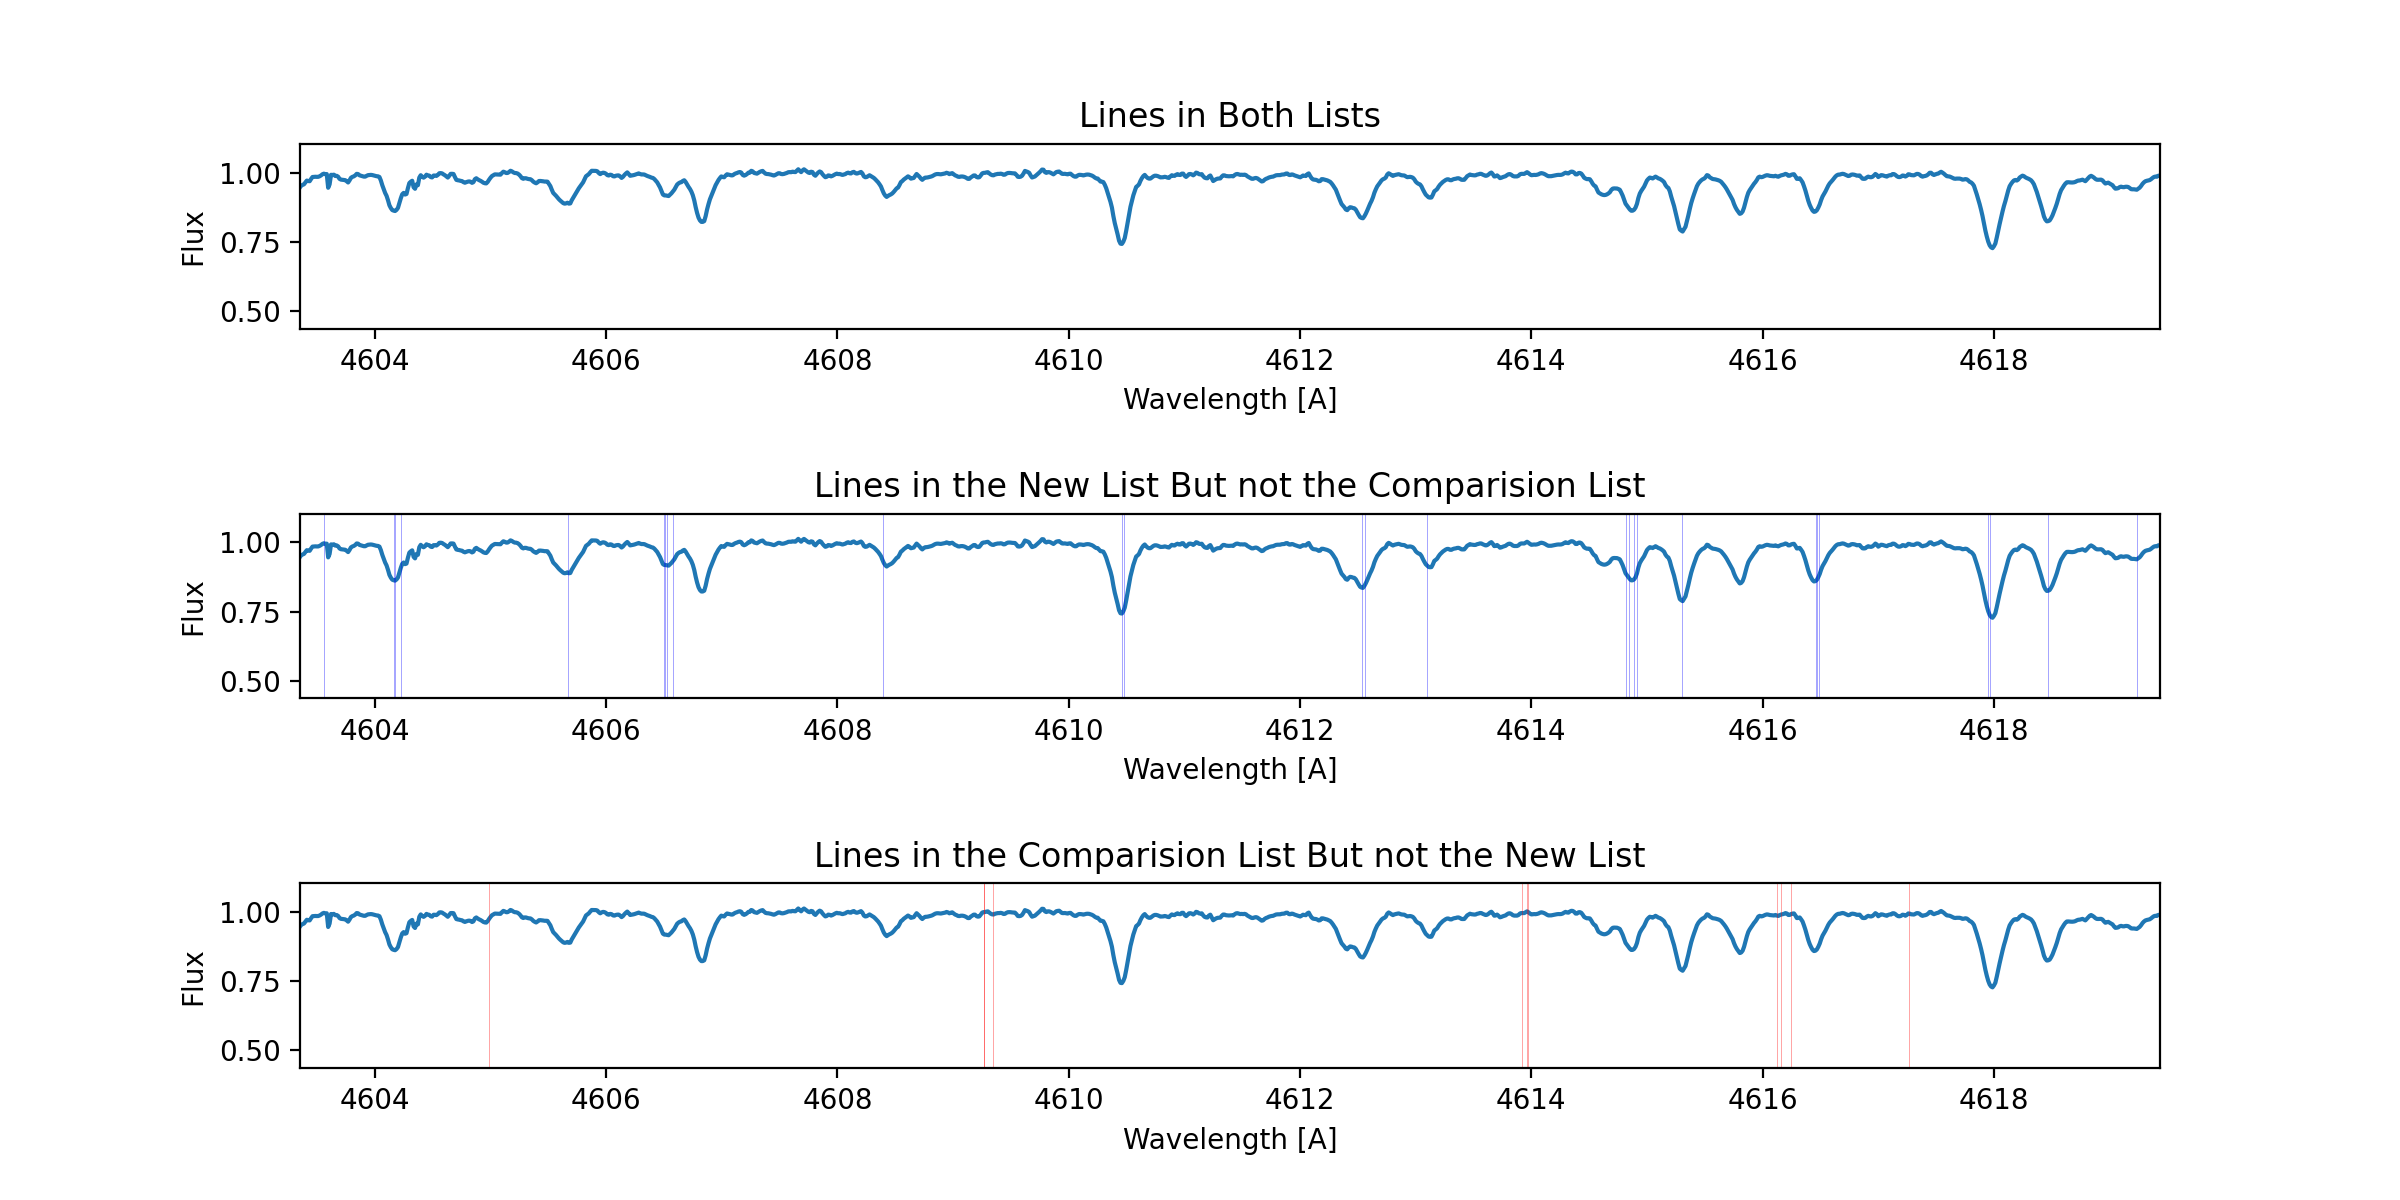

In [270]:
plt.figure(figsize=(12,6))

ax1 = plt.subplot(311)
plt.title('Lines in Both Lists')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

plt.plot(w , f )


ymin, ymax = ax1.get_ylim()
ax1.set_ylim(ymin,ymax)

    
for wi in inBoth:
    plt.vlines( wi, ymin, ymax, color='green', linewidth=0.25, alpha=0.5, zorder=2 )

    
# ---------------------------------------
ax2 = plt.subplot(312, sharex=ax1, sharey=ax1)
plt.title('Lines in the New List But not the Comparision List')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.plot(w,f)

for wi in inMine_notCompare:
    plt.vlines( wi, ymin, ymax, color='blue', linewidth=0.25, alpha=0.5, zorder=2 )
    

# ---------------------------------------
ax1 = plt.subplot(313, sharex=ax1, sharey=ax1)
plt.title('Lines in the Comparision List But not the New List')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

plt.plot(w , f )

    
for wi in inCompare_notMine:
    plt.vlines( wi, ymin, ymax, color='red', linewidth=0.25, alpha=0.5, zorder=2 )
    
    
plt.subplots_adjust(hspace=1)

# plt.figlegend(lines, labels, loc = 'lower center', ncol=5, labelspacing=0.)
